### Postprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scanpy as sc
import os
import cell2location

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

/home/maike/.conda/envs/cell2loc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/maike/.conda/envs/cell2loc_env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/maike/.conda/envs/cell2loc_env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/maike/.conda/envs/cell2loc_env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/maike/.conda/envs/cell2loc_env/lib/python3.10/s

In [11]:

FCER1G_Directed_genes = [
    "CD68", "MS4A4A", "MRC1", "CYBB", "FCER1G",
    "FCGR2A", "CD163", "C1QC", "LY96", "NCF4", "F13A1",
    "FOLR2", "VSIG4", "C1QB", "MPEG1", "C3AR1", "CTSD",
    "AIF1", "C1QA", "MS4A6A", "CSF1R", "CTSZ", "ITGAM"
]

NADPH = ['CYBA','CYBB','NCF2','NCF4','NCF1','RAC1','RAC2']

clust_labels = ['AD_FCER1G+M2', 'Macro_2', 'Macro_1', 'Mono_mac', 'DC', 'Tc', 'Th', 'LC', 'KC','Fibroblasts'] 

# dictionary with crop coordinates for each sample to use in the plot_genes_per_cell_type_crop function
dict_crop = {
    'AD_2_NL': (6000, 10000, 5000, 13000),
    'AD_3_NL': (3000, 10000, 4000, 12000),
    'AD_4_LS': (3000, 12000, 4000, 12000),
    'AD_5_LS': (2000, 10000, 4000, 11500),
    'AD_5_NL': (1500, 10000, 4000, 11500),
    'AD_6_LS': (4000, 12000, 2000, 9000),
    'AD_6_NL': (9000, 17000, 4000, 10000),
    'AD_7_NL': (2500, 10000, 1500, 11500),
    'AD_7_LS': (2500, 11000, 2000, 10000),
    'HE_2': (1500, 6000, 3000, 6000),
    'HE_3': (11000, 18000, 9000, 16000),
    'HE_4': (12000, 18000, 4000, 14000),
    'HE_5_1': (8000, 16000, 11000, 17000),
    'HE_5_2': (1000, 8000, 2000, 11000)
}

# for the other samples add None as crop coordinates
dict_crop['AD_1_LS'] = None
dict_crop['AD_2_LS'] = None
dict_crop['AD_3_LS'] = None
dict_crop['AD_1_NL'] = None
dict_crop['AD_4_NL'] = None
dict_crop['HE_1'] = None

# Functions to plot the spatial expression of the genes

def plot_stuff(adata, genes, sample, crop = None):
    # plot in spatial coordinates    
    
    with mpl.rc_context({'axes.facecolor':  'white',
                        'figure.figsize': [4.5, 5]}):
        sc.pl.spatial(adata, cmap='magma',
                    # show first 8 cell types
                    color= genes,
                    ncols=5, size=1.3,
                    crop_coord= crop,
                    img_key='lowres',
                    # limit color scale at 99.2% quantile of cell abundance
                    vmin=0, vmax=1,#'p99.2',
                    show=False
                    )
        plt.tight_layout()
        plt.show()
        """ plt.savefig(f"/home/yang/Spacial_Transcriptomics/Plots/{sample}1_ctoi.pdf", 
                    format="pdf", 
                    bbox_inches='tight', 
                    dpi=300) """
        plt.close()  # Close the figure to free up memory
        
    """ with mpl.rc_context({'axes.facecolor':  'white',
                    'figure.figsize': [4.5, 5]}):
        sc.pl.spatial(adata, cmap='magma',
                    # show first 8 cell types
                    color= genes,
                    ncols=4, size=1.3,
                    img_key='lowres',
                    # limit color scale at 99.2% quantile of cell abundance
                    vmax='p99.2',
                    show=False
                    )
        plt.tight_layout()
        plt.savefig(f"/home/yang/Spacial_Transcriptomics/Plots/{sample}2_ctoi.pdf", 
                    format="pdf", 
                    bbox_inches='tight', 
                    dpi=300)
        plt.close()  # Close the figure to free up memory """

# Plot the spatial expression of the genes
def show_stuff(adata, genes):
  with mpl.rc_context({'axes.facecolor':  'white',
                        'figure.figsize': [4.5, 5]}):
        sc.pl.spatial(adata, cmap='Reds',
                    # show first 8 cell types
                    color= genes,
                    ncols=4, size=1.3,
                    img_key='lowres',
                    # limit color scale at 99.2% quantile of cell abundance
                    #vmin=0, vmax=1,#'p99.2',
                    show=True
                    )

# Normalize the data using min-max scaling to get values between 0 and 1 for each sample
def min_max_scaling(data):
        
    min_values = data.min(axis=1)
    max_values = data.max(axis=1)
    normalized_data = data.sub(min_values, axis=0).div(max_values - min_values, axis=0)
    
    return normalized_data

def process_file(path, sample, crop):
    adata = sc.read_h5ad(path)
    # log normalize the data
    
    adata.X = adata.layers['imputed']
    #sc.pp.normalize_total(adata, target_sum=1e4)
    #sc.pp.log1p(adata)
    
    # scale the data
    adata.obsm['q05_cell_abundance_w_sf'] = min_max_scaling(adata.obsm['q05_cell_abundance_w_sf'])
    
    adata.obs[adata.uns['mod']['factor_names']] = adata.obsm['q05_cell_abundance_w_sf']
    
    sc.tl.score_genes(adata, FCER1G_Directed_genes, score_name='FCER1G_Directed_genes',use_raw=False)
    sc.tl.score_genes(adata, NADPH, score_name='NADPH_genes',use_raw=False)
    #show_stuff(adata, ["FCER1G", "AD_FCER1G+M2", "FCER1G_Directed_genes", "NADPH_genes",])
    
    plot_stuff(adata, clust_labels, sample, crop )
    # write the adata objects to a file
    #adata.write(path)
    
def plot_genes_per_cell_type_crop(slide, genes, ctypes, crop=None):
    
    FCER1G_Directed_genes = [
    "CD68", "MS4A4A", "MRC1", "CYBB", "FCER1G",
    "FCGR2A", "CD163", "C1QC", "LY96", "NCF4", "F13A1",
    "FOLR2", "VSIG4", "C1QB", "MPEG1", "C3AR1", "CTSD",
    "AIF1", "C1QA", "MS4A6A", "CSF1R", "CTSZ", "ITGAM"
    ]

    NADPH = ['CYBA','CYBB','NCF2','NCF4','NCF1','RAC1','RAC2']
    n_genes = len(genes)
    n_ctypes = len(ctypes)
    n_cols = 8
    n_rows_per_gene = 3
    
    fig, axs = plt.subplots(
        nrows=n_genes * n_rows_per_gene, 
        ncols=n_cols, 
        figsize=(4.5 * n_cols + 2, 5 * n_genes * n_rows_per_gene + 1), 
        squeeze=False
    )
    
    # plots of every gene
    for j in range(n_genes):
        
         # get vmax value for each row of plots
        max = 0
        quant = 0
        
        for i in range(n_ctypes):
            slide.X = slide.layers[ctypes[i]]
            
            if genes[j] == 'NADPH_genes':
                sc.tl.score_genes(slide, NADPH, score_name='NADPH_genes',use_raw=False)
                max = np.max([max, slide.obs["NADPH_genes"].max()])
                quant = np.max([quant, np.quantile(slide.obs["NADPH_genes"], 0.992)])
            elif genes[j] == 'FCER1G_Directed_genes':
                sc.tl.score_genes(slide, FCER1G_Directed_genes, score_name='FCER1G_Directed_genes',use_raw=False)
                max = np.max([max, slide.obs["FCER1G_Directed_genes"].max()])
                quant = np.max([quant, np.quantile(slide.obs["FCER1G_Directed_genes"], 0.992)])
            else:      
                quant = np.max([quant, np.quantile(slide.layers[ctypes[i]][:, slide.var["SYMBOL"] == genes[j]].toarray(), 0.992)])

        
        slide.X = slide.layers["imputed"]
        sc.tl.score_genes(slide, FCER1G_Directed_genes, score_name='FCER1G_Directed_genes',use_raw=False)
        sc.tl.score_genes(slide, NADPH, score_name='NADPH_genes',use_raw=False)
    
        # Plot overall expression
        sc.pl.spatial(
            slide,
            cmap="magma",
            color=genes[j],
            gene_symbols="SYMBOL",
            crop_coord= crop,
            size=1.3,
            img_key="lowres",
            vmin=0,
            vmax=quant,
            ax=axs[j * n_rows_per_gene, 0],
            show=False,
        )
        axs[j * n_rows_per_gene, 0].set_title(f"{genes[j]} (Overall)")
        
        if genes[j] == 'NADPH_genes' or genes[j] == 'FCER1G_Directed_genes':
            
            # plots of every cell type
            for i in range(n_ctypes):
                row = (j * n_rows_per_gene) + (i // n_cols)
                col = (i % n_cols) + 1 if i < n_cols - 1 else i % n_cols
                # computing scores for each of the cell types
                slide.X = slide.layers[ctypes[i]]
                sc.tl.score_genes(slide, FCER1G_Directed_genes, score_name='FCER1G_Directed_genes',use_raw=False)
                sc.tl.score_genes(slide, NADPH, score_name='NADPH_genes',use_raw=False)
                sc.pl.spatial(
                    slide,
                    cmap="magma",
                    color=genes[j],
                    layer=ctypes[i],
                    gene_symbols="SYMBOL",
                    crop_coord= crop,
                    ncols=4,
                    size=1.3,
                    img_key="lowres",
                    # limit color scale at 99.2% quantile of gene expression
                    vmin=0,
                    vmax=quant,#"p99.2", #quantile_across_ct,
                    ax=axs[row, col],
                    show=False,
                )
                axs[row, col].set_title(f"{genes[j]} {ctypes[i]}")
        else:
            # plots of every cell type
            for i in range(n_ctypes):
                row = (j * n_rows_per_gene) + (i // n_cols)
                col = (i % n_cols) + 1 if i < n_cols - 1 else i % n_cols
                # computing scores for each of the cell types
                slide.X = slide.layers[ctypes[i]]
                sc.tl.score_genes(slide, FCER1G_Directed_genes, score_name='FCER1G_Directed_genes',use_raw=False)
                sc.tl.score_genes(slide, NADPH, score_name='NADPH_genes',use_raw=False)
                sc.pl.spatial(
                    slide,
                    cmap="magma",
                    color=genes[j],
                    layer=ctypes[i],
                    crop_coord= crop,
                    gene_symbols="SYMBOL",
                    ncols=4,
                    size=1.3,
                    img_key="lowres",
                    # limit color scale at 99.2% quantile of gene expression
                    vmin=0,
                    vmax=quant,#"p99.2", #quantile_across_ct,
                    ax=axs[row, col],
                    show=False,
                )
                axs[row, col].set_title(f"{genes[j]} {ctypes[i]}")

            # Hide unused subplots
            for i in range(n_ctypes + 1, n_rows_per_gene * n_cols):
                row = (j * n_rows_per_gene) + (i // n_cols)
                col = i % n_cols
                axs[row, col].axis('off')

    return fig, axs

def pre_and_plot(folder, genes, ctypes, crop = None):
    adata = sc.read_h5ad(folder + "/_sp.h5ad")
    adata.X = adata.layers["raw_count"]
    mod = cell2location.models.Cell2location.load(folder, adata)

    adata.X = adata.layers["imputed"]

    mod.export_posterior(adata)

    # Compute expected expression per cell type
    expected_dict = mod.module.model.compute_expected_per_cell_type(
        mod.samples["post_sample_q05"], mod.adata_manager
    )

    # Add to anndata layers
    for i, n in enumerate(mod.factor_names_):
        adata.layers[n] = expected_dict['mu'][i]    
        
    adata.var["SYMBOL"] = adata.var.index
    # get sample name from folder path to use for accessing crop coordinates
    sample = folder.split('/')[-1].split('_')[3:]
    sample = '_'.join(sample)
    
        
    if sample == 'HE_5':
        with mpl.rc_context({'axes.facecolor':  'black'}):
            fig, axs = plot_genes_per_cell_type_crop(adata, genes, ctypes, crop = dict_crop[sample+'_1'])
            plt.tight_layout()
            """ plt.savefig(f"/home/yang/Spacial_Transcriptomics/Plots/{sample}_1_genes.pdf", 
                        format="pdf", 
                        bbox_inches='tight', 
                        dpi=300) """

        with mpl.rc_context({'axes.facecolor':  'black'}):
            fig, axs = plot_genes_per_cell_type_crop(adata, genes, ctypes, crop = dict_crop[sample+'_2'])
            plt.tight_layout()
            """ plt.savefig(f"/home/yang/Spacial_Transcriptomics/Plots/{sample}_2_genes.pdf", 
                        format="pdf", 
                        bbox_inches='tight', 
                        dpi=300) """
    else:
        with mpl.rc_context({'axes.facecolor':  'black'}):
            fig, axs = plot_genes_per_cell_type_crop(adata, genes, ctypes, crop = dict_crop[sample])
            plt.tight_layout()
            """ plt.savefig(f"/home/yang/Spacial_Transcriptomics/Plots/{sample}_genes.pdf", 
                        format="pdf", 
                        bbox_inches='tight', 
                        dpi=300) """ 
    plt.show()
    plt.close()

### Creating plots that shows the expression of selected genes and cell types for each section of a sample in our dataset.

In [4]:

# loading arbitrary file to get the list of cell        
adata = sc.read_h5ad("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907082_AD_6_LS/_sp.h5ad")
# list cell types and genes for plotting
ctypes= adata.uns["mod"]["factor_names"]
genes = ["FCER1G", "NADPH_genes", "FCER1G_Directed_genes"]
NADPH = ['CYBA','CYBB','NCF2','NCF4','NCF1','RAC1','RAC2']

# get all folders in the directory /home/maike/Spacial_Transcriptomics/Cell2Location_analysis
folders = [f.path for f in os.scandir("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis") if f.is_dir()]
# remove the folders that include "reference" in their name
folders = [f for f in folders if "reference" not in f]
folders



NameError: name 'os' is not defined

In [2]:
pre_and_plot(folders[0], genes, ctypes) ### This code will generate plots

In [ ]:
### Running the plotting per cell type for  all samples

In [ ]:

for folder in folders:
    pre_and_plot(folder, genes, ctypes)
    print(folder)
    print("done")
    print("\n")

### Creating plot that shows selected cell types.

/tmp/ipykernel_1690313/3272861598.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


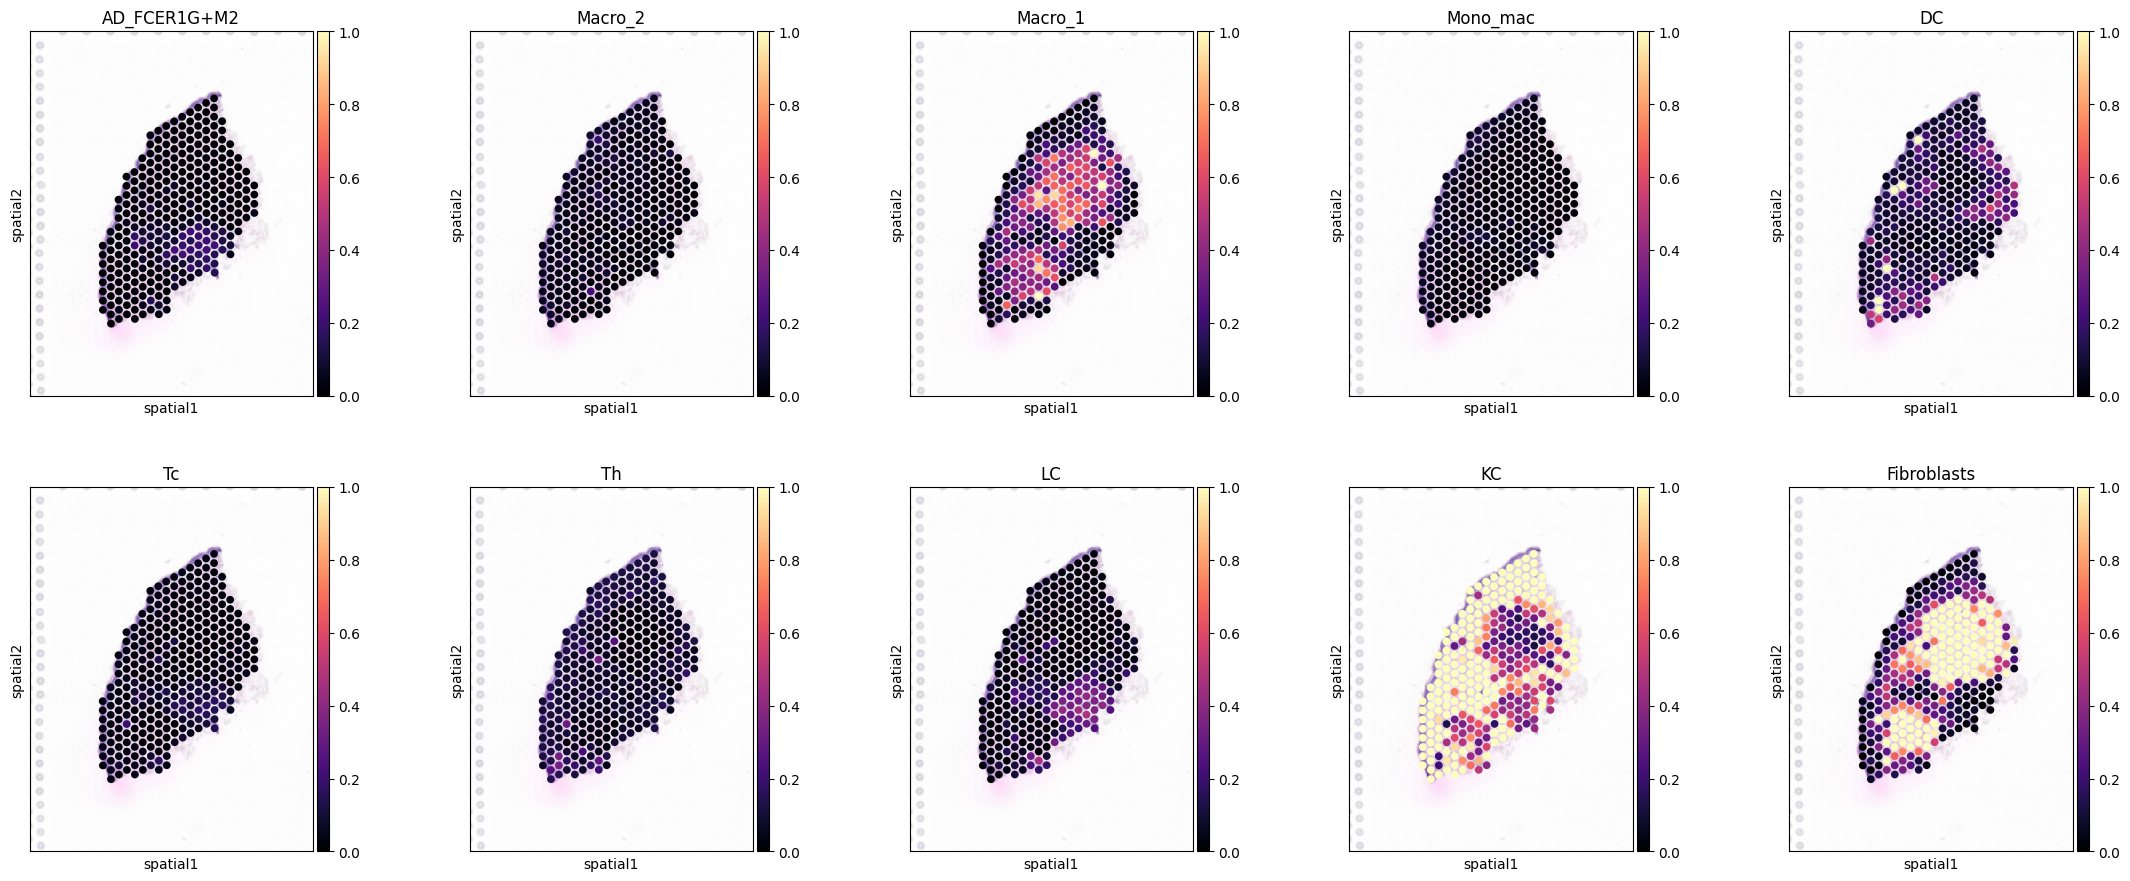

In [8]:
#process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907085_AD_2_NL/_sp.h5ad", 'AD_2_NL', crop = (6000, 10000, 5000, 13000))
#process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907086_AD_3_NL/_sp.h5ad", 'AD_3_NL', crop = (3000, 10000, 4000, 12000))
#process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907080_AD_4_LS/_sp.h5ad", 'AD_4_LS', crop = (3000, 12000, 4000, 12000))
#process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907081_AD_5_LS/_sp.h5ad", 'AD_5_LS', crop = (2000, 10000, 4000, 11500))  #wrong crop cause accidentally deleted
#process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907088_AD_5_NL/_sp.h5ad", 'AD_5_NL', crop = (1500, 10000, 4000, 11500))
#process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907082_AD_6_LS/_sp.h5ad", "AD_6_LS", crop = (4000, 12000, 2000, 9000))
#process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907089_AD_6_NL/_sp.h5ad", 'AD_6_NL', crop = (9000, 17000, 4000, 10000))
#process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907090_AD_7_NL/_sp.h5ad", 'AD_7_NL', crop = (2500, 10000, 1500, 11500))
#process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907083_AD_7_LS/_sp.h5ad", 'AD_7_LS', crop = (2500, 11000, 2000, 10000))
#process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907092_HE_2/_sp.h5ad", 'HE_2', crop = (1500, 6000, 3000, 6000))
#process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907093_HE_3/_sp.h5ad", 'HE_3', crop = (11000, 18000, 9000, 16000))
#process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907094_HE_4/_sp.h5ad", 'HE_4', crop = (12000, 18000, 4000, 14000))
#process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907095_HE_5/_sp.h5ad", 'HE_5', crop = (8000, 16000, 11000, 17000))
process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907095_HE_5/_sp.h5ad", 'HE_5', crop = (1000, 8000, 2000, 11000))

In [ ]:
""" # Before cropping
process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907077_AD_1_LS/_sp.h5ad", 'AD_1_LS')
process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907078_AD_2_LS/_sp.h5ad", 'AD_2_LS')
process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907080_AD_4_LS/_sp.h5ad", 'AD_4_LS')
process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907081_AD_5_LS/_sp.h5ad", 'AD_5_LS')
process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907082_AD_6_LS/_sp.h5ad", "AD_6_LS")
process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907083_AD_7_LS/_sp.h5ad", 'AD_7_LS')

process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907084_AD_1_NL/_sp.h5ad", 'AD_1_NL')
process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907085_AD_2_NL/_sp.h5ad", 'AD_2_NL')
process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907086_AD_3_NL/_sp.h5ad", 'AD_3_NL')
process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907088_AD_5_NL/_sp.h5ad", 'AD_5_NL')
process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907089_AD_6_NL/_sp.h5ad", 'AD_6_NL')
process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907090_AD_7_NL/_sp.h5ad", 'AD_7_NL')

process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907091_HE_1/_sp.h5ad", 'HE_1')
process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907092_HE_2/_sp.h5ad", 'HE_2')
process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907093_HE_3/_sp.h5ad", 'HE_3')
process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907094_HE_4/_sp.h5ad", 'HE_4')
process_file("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907095_HE_5/_sp.h5ad", 'HE_5') 
"""

In [59]:
""" # Load result data
adata = sc.read_h5ad("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map/AD_6_LS_sp.h5ad")"""
#adata = sc.read_h5ad("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907089_AD_6_NL/_sp.h5ad")
"""
adata = sc.read_h5ad("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907084_AD_1_NL/_sp.h5ad")
adata = sc.read_h5ad('/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907085_AD_2_NL/_sp.h5ad')
adata = sc.read_h5ad('/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907086_AD_3_NL/_sp.h5ad')
adata = sc.read_h5ad('/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907088_AD_5_NL/_sp.h5ad')
adata = sc.read_h5ad('/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907090_AD_7_NL/_sp.h5ad')

adata = sc.read_h5ad('/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907077_AD_1_LS/_sp.h5ad')
adata = sc.read_h5ad('/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907078_AD_2_LS/_sp.h5ad')
adata = sc.read_h5ad('/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907079_AD_3_LS/_sp.h5ad')
 """
#adata_LS = sc.read_h5ad("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map/AD_6_LS_sp.h5ad")
#adata_NL = sc.read_h5ad("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907089_AD_6_NL/_sp.h5ad")
#adata_HE = sc.read_h5ad("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907095_HE_5/_sp.h5ad")

#adata_LS = sc.read_h5ad("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907082_AD_6_LS/_sp.h5ad")
#adata_NL = sc.read_h5ad("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907089_AD_6_NL/_sp.h5ad")
#adata_HE = sc.read_h5ad("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907095_HE_5/_sp.h5ad")
adata_LS_1 = sc.read_h5ad("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907077_AD_1_LS/_sp.h5ad")

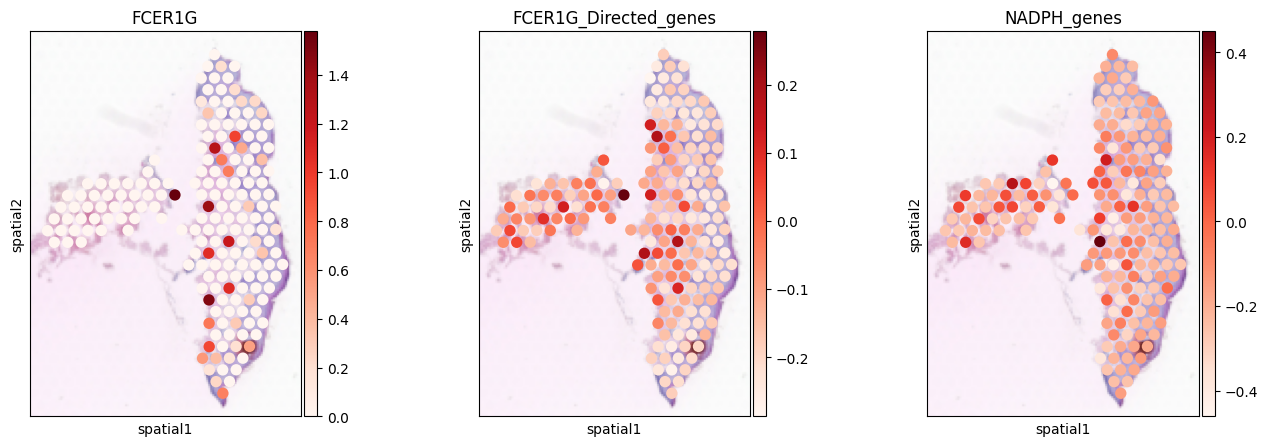

In [70]:
adata_LS_1 = sc.read_h5ad("/home/yang/Spacial_Transcriptomics/Cell2Location_analysis/cell2location_map_GSM5907077_AD_1_LS/_sp.h5ad")

show_stuff(adata_LS_1, ["FCER1G", "FCER1G_Directed_genes", "NADPH_genes"])